In [86]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Neural Net libraries. 
# I installed the live version of lasagne, theano, and nolearn directly from git.
# https://github.com/dnouri/nolearn
from lasagne import layers
from lasagne import nonlinearities
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

ImportError: No module named pyplot

In [3]:
data = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/train.csv")
test = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/test.csv")


In [4]:
# Big Picture of Data
print "Train Data:"
print data.shape
print data.columns.values
print "Test Data:"
print test.shape
print test.columns.values


Train Data:
(878049, 9)
['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y']
Test Data:
(884262, 7)
['Id' 'Dates' 'DayOfWeek' 'PdDistrict' 'Address' 'X' 'Y']


In [5]:
# Add a column counting days since the min date in the dataset
def add_date_diff(df):
    datetime_vector = pd.to_datetime(df['Dates'])
    date_vector = datetime_vector.dt.date
    date_diff_vector = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    df['DateDiff'] = date_diff_vector

add_date_diff(data)
add_date_diff(test)
#print data.DateDiff.describe()
#print test.DateDiff.describe()


In [61]:
# Lasagne works off of Theano instead of Numpy
#print data.Category

xxxx = pd.Categorical(data.Category).labels
np_xxxx = np.array(xxxx).astype(np.int32)
print np_xxxx
print train_labels

[37 21 21 ..., 16 35 12]
['WARRANTS' 'OTHER OFFENSES' 'OTHER OFFENSES' ..., 'LARCENY/THEFT'
 'LARCENY/THEFT' 'FORGERY/COUNTERFEITING']


In [6]:
# Create random dev sample so we can see how that accuracy compares to our Kaggle results
# np.random.seed(100)

# Pick 10% of rows for dev
# rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

# dev = data.ix[rows]
# train = data.drop(rows)

# print train.shape
# print dev.shape
# print test.shape


(790245, 10)
(87804, 10)
(884262, 8)


In [7]:
# Convert to Numpy Format
# TODO: Add more features here
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test[['DateDiff','X','Y']].values)

# Normalize Data to Between 0-1
# a + (x-A)*(b-a)/(B-A) 
# TODO: Fix normalization to kick out "bad" x/y
train_normed = 0 + (np.abs(train_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
dev_normed = 0 + (np.abs(dev_data) - np.abs(dev_data).min(axis=0))*(1-0)/(np.abs(dev_data).max(axis=0) - np.abs(dev_data).min(axis=0)) 

print train_normed.min(axis=0)
print train_normed.max(axis=0)

[ 0.  0.  0.]
[ 1.  1.  1.]


In [82]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 3),  # 3 input pixels per batch
    hidden_num_units=10,  # number of units in hidden layer
    #output_nonlinearity=None,  # output layer uses identity function
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.1,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=10,  # we want to train this many epochs
    verbose=1,
    )

#train_prime = np.array(train[['Y']].values)
#print train_prime.shape
#print train_prime
#print train_labels
#X.astype(np.float32)
#y = y.astype(np.int32)
train_data2 = train_data.astype(np.float64)
train_labels2 = pd.Categorical(train[['Category']].values.ravel()).labels
train_labels3 = np.array(train_labels2).astype(np.int32)

#train_labels2 = train_data.astype(np.int32)
net1.fit(train_data2, train_labels3)

# Neural Network with 469 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input        3
  1  hidden      10
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1     545.34009       2.71255    201.04358      0.14341  1.67s
      2       2.63431       2.71218      0.97129      0.14341  1.77s
      3       2.63421       2.71212      0.97127      0.14341  1.65s
      4       2.63417       2.71209      0.97127      0.14341  1.70s
      5       2.63415       2.71208      0.97127      0.14341  1.69s
      6       2.63414       2.71207      0.97127      0.14341  1.67s
      7       2.63414       2.71206      0.97127      0.14341  1.57s
      8       2.63413       2.71206      0.97127      0.14341  1.64s
      9       2.63413       2.71206      0.97127      0.14341  1.64s
     10       2.63413       2.71205      0.97127      0.14341  1.67s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c727450>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c7273d0>,
     custom_score=None, hidden_num_units=10, input_shape=(None, 3),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x10c72a938>,
     objective_loss_function=<function categorical_crossentropy at 0x10c645a28>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x116eb60e0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x116eb69e0>],
     output_nonlinearity=<function softmax at 0x10c4fa140>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit object at

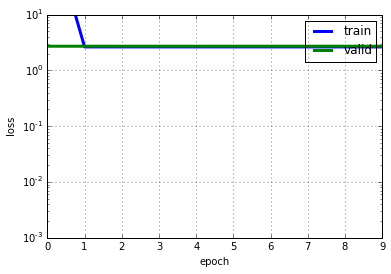

In [93]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e1)
plt.yscale("log")
plt.show()

# Looks pretty bad!

In [116]:
dev_predict = net1.predict(dev_data)
print dev_predict
print dev_predict.mean()
#print "The NN with DateDiff, X and Y scores: {:.6f}".format(metrics.f1_score(dev_labels, dev_predict, average='weighted'))

uni = pd.Categorical(train[['Category']].values.ravel()).unique()
for x, i in enumerate(uni):
    print x+1, i
#pd.Categorical(train[['Category']].values.ravel()).labels

[21 21 21 ..., 21 21 21]
21.0
1 ARSON
2 ASSAULT
3 BAD CHECKS
4 BRIBERY
5 BURGLARY
6 DISORDERLY CONDUCT
7 DRIVING UNDER THE INFLUENCE
8 DRUG/NARCOTIC
9 DRUNKENNESS
10 EMBEZZLEMENT
11 EXTORTION
12 FAMILY OFFENSES
13 FORGERY/COUNTERFEITING
14 FRAUD
15 GAMBLING
16 KIDNAPPING
17 LARCENY/THEFT
18 LIQUOR LAWS
19 LOITERING
20 MISSING PERSON
21 NON-CRIMINAL
22 OTHER OFFENSES
23 PORNOGRAPHY/OBSCENE MAT
24 PROSTITUTION
25 RECOVERED VEHICLE
26 ROBBERY
27 RUNAWAY
28 SECONDARY CODES
29 SEX OFFENSES FORCIBLE
30 SEX OFFENSES NON FORCIBLE
31 STOLEN PROPERTY
32 SUICIDE
33 SUSPICIOUS OCC
34 TREA
35 TRESPASS
36 VANDALISM
37 VEHICLE THEFT
38 WARRANTS
39 WEAPON LAWS


In [11]:
#OLD - NOT USING Fit a basic RBM

#NNmodel = BernoulliRBM()
#NNmodel.fit(train_data, train_labels)


AttributeError: 'BernoulliRBM' object has no attribute 'predict'

Code Below this point is from KNN - here to steal bits from while I work on NN.

In [9]:
# Use GridSearchCV to find a good number of neighbors.
#ks = {'n_neighbors': range(1,4)}
ks = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNNGridSearch = GridSearchCV(KNeighborsClassifier(), ks, scoring='f1_weighted')
KNNGridSearch.fit(train_data, train_labels)

# Report out on the accuracies    
print "The scores for each k value was %s " % (KNNGridSearch.grid_scores_)
print "The best k value was %s with accuracy %.4f" % (KNNGridSearch.best_params_, KNNGridSearch.best_score_)


The scores for each k value was [mean: 0.00303, std: 0.00382, params: {'n_neighbors': 1}, mean: 0.00314, std: 0.00389, params: {'n_neighbors': 2}, mean: 0.00300, std: 0.00380, params: {'n_neighbors': 3}, mean: 0.00302, std: 0.00378, params: {'n_neighbors': 4}, mean: 0.00299, std: 0.00371, params: {'n_neighbors': 5}, mean: 0.00300, std: 0.00373, params: {'n_neighbors': 6}, mean: 0.00297, std: 0.00372, params: {'n_neighbors': 7}, mean: 0.00297, std: 0.00371, params: {'n_neighbors': 8}, mean: 0.00295, std: 0.00369, params: {'n_neighbors': 9}, mean: 0.00295, std: 0.00368, params: {'n_neighbors': 10}] 
The best k value was {'n_neighbors': 2} with accuracy 0.0031


In [12]:
# Try k = 2
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(train_data, train_labels)
dev_predict = KNNmodel.predict(dev_data)
print "The KNN with DateDiff, X and Y (k=2) scores: {:.6f}".format(metrics.f1_score(dev_labels, dev_predict, average='weighted'))


# Tried a few tests (including the above). So far k=1 seems best.

The KNN with DateDiff, X and Y (k=2) scores: 0.220072


Great, now we've sorted out a naive alg to run. Let's train on all train, then predict on test

In [28]:
def create_submission(preds):
    labels = ["Id",
                "ARSON",
                "ASSAULT",
                "BAD CHECKS",
                "BRIBERY",
                "BURGLARY",
                "DISORDERLY CONDUCT",
                "DRIVING UNDER THE INFLUENCE",
                "DRUG/NARCOTIC",
                "DRUNKENNESS",
                "EMBEZZLEMENT",
                "EXTORTION",
                "FAMILY OFFENSES",
                "FORGERY/COUNTERFEITING",
                "FRAUD",
                "GAMBLING",
                "KIDNAPPING",
                "LARCENY/THEFT",
                "LIQUOR LAWS",
                "LOITERING",
                "MISSING PERSON",
                "NON-CRIMINAL",
                "OTHER OFFENSES",
                "PORNOGRAPHY/OBSCENE MAT",
                "PROSTITUTION",
                "RECOVERED VEHICLE",
                "ROBBERY",
                "RUNAWAY",
                "SECONDARY CODES",
                "SEX OFFENSES FORCIBLE",
                "SEX OFFENSES NON FORCIBLE",
                "STOLEN PROPERTY",
                "SUICIDE",
                "SUSPICIOUS OCC",
                "TREA",
                "TRESPASS",
                "VANDALISM",
                "VEHICLE THEFT",
                "WARRANTS",
                "WEAPON LAWS"
              ]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    # Write results to csv
    np.savetxt('sample.csv', results, fmt='%d', delimiter=',', header=head_str, comments='')

    return results

In [17]:
# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(full_data, full_labels)
dev_predict = KNNmodel.predict_proba(test_data).astype(int)

In [29]:
results = create_submission(dev_predict)

In [30]:
print results.shape

(884262, 40)
